# <center>----HR Retention Analysis---- </center>
### Step 1. Import Libraries

In [43]:
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Model Selection & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Configuration for cleaner charts
sns.set(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


## Step 2: Data Loading and Cleaning

In [44]:
# --- Step 2: Data Loading and Cleaning ---
file_path = 'HR_comma_sep.csv'

data = pd.read_csv(file_path)
print(f"Successfully loaded '{file_path}'.")
    
# Rename columns for clarity
data = data.rename(columns={
    'satisfaction_level': 'SatisfactionLevel',
    'last_evaluation': 'LastEvaluation',
    'number_project': 'NumberofProjects',
    'average_montly_hours': 'AverageMonthlyHours',
    'time_spend_company': 'TimeSpentAtCompany',
    'Work_accident': 'WorkAccident',
    'left': 'Left', 
    'promotion_last_5years': 'PromotionsInLast5Years',
    'sales': 'Department',
    'salary': 'Salary'
})

Successfully loaded 'HR_comma_sep.csv'.


In [45]:
# Verify data rows
data.head()

,SatisfactionLevel,LastEvaluation,NumberofProjects,AverageMonthlyHours,TimeSpentAtCompany,WorkAccident,Left,PromotionsInLast5Years,Department,Salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [46]:
print("--- Data Structure ---")
data.info()

--- Data Structure ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SatisfactionLevel       14999 non-null  float64
 1   LastEvaluation          14999 non-null  float64
 2   NumberofProjects        14999 non-null  int64  
 3   AverageMonthlyHours     14999 non-null  int64  
 4   TimeSpentAtCompany      14999 non-null  int64  
 5   WorkAccident            14999 non-null  int64  
 6   Left                    14999 non-null  int64  
 7   PromotionsInLast5Years  14999 non-null  int64  
 8   Department              14999 non-null  object 
 9   Salary                  14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [47]:
print("\n--- Missing Values ---")
print(data.isnull().sum())


--- Missing Values ---
SatisfactionLevel         0
LastEvaluation            0
NumberofProjects          0
AverageMonthlyHours       0
TimeSpentAtCompany        0
WorkAccident              0
Left                      0
PromotionsInLast5Years    0
Department                0
Salary                    0
dtype: int64


## Step 3: EDA

### 3.1 Correlation Matrix

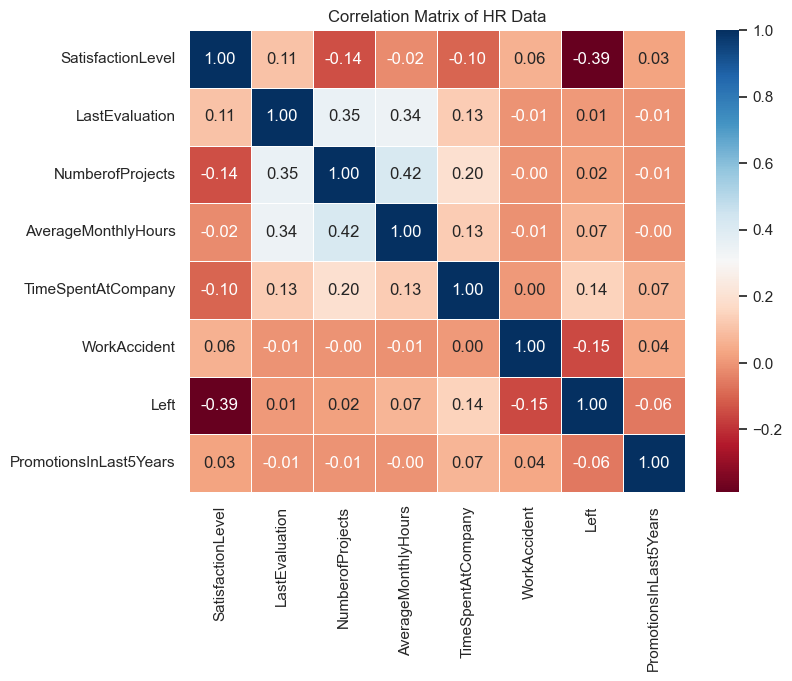

In [48]:
# Step 3: EDA
# 3.1 Correlation Matrix
plt.figure(figsize=(8, 6))
correlation_matrix = data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of HR Data')
plt.show()

**Largest Factor**  
We can see that satisfaction level has the highest coorelation with one's decision to stay or leave

### 3.2 Turnover By Department  

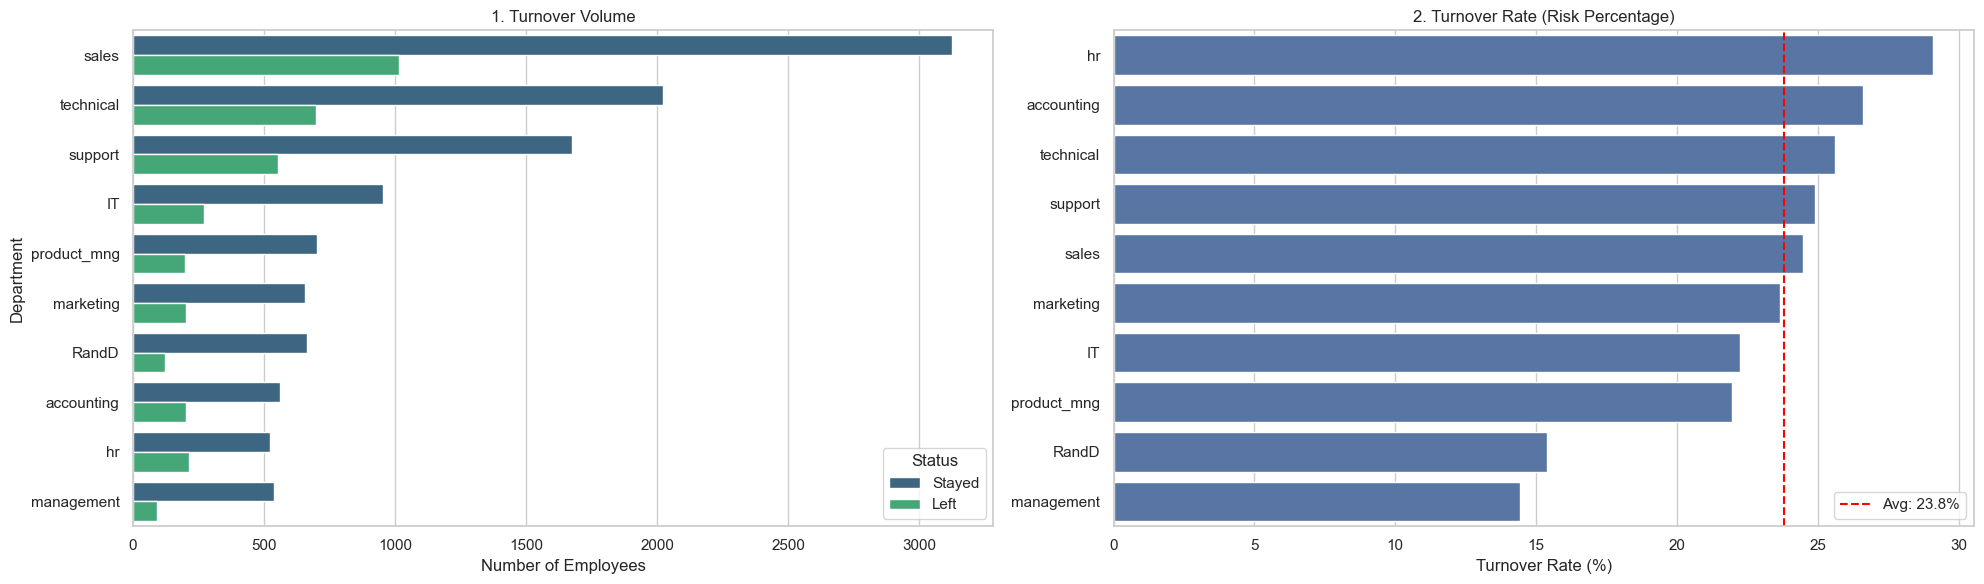

In [49]:
# 3.2 Turnover By Department: Volume vs Rate
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# --- Chart 1: The Volume (Sorted by Size) ---
# 1. Calculate the order (Biggest departments first)
volume_order = data['Department'].value_counts().index

sns.countplot(
    y='Department', 
    hue='Left', 
    data=data, 
    palette='viridis',
    order=volume_order, 
    ax=axes[0]
)
axes[0].set_title('1. Turnover Volume')
axes[0].set_xlabel('Number of Employees')
axes[0].legend(title='Status', labels=['Stayed', 'Left'])


# --- Chart 2: The Rate (Sorted by Risk) ---
# Calculate rates
dept_counts = data.groupby(['Department', 'Left']).size().unstack()
dept_counts['Turnover_Rate'] = (dept_counts[1] / (dept_counts[0] + dept_counts[1])) * 100
dept_counts = dept_counts.sort_values(by='Turnover_Rate', ascending=False)

sns.barplot(
    x=dept_counts['Turnover_Rate'], 
    y=dept_counts.index,  
    ax=axes[1]
)
axes[1].set_title('2. Turnover Rate (Risk Percentage)')
axes[1].set_xlabel('Turnover Rate (%)')
axes[1].set_ylabel('') 

# Add average line
avg_turnover = (data['Left'].mean() * 100)
axes[1].axvline(avg_turnover, color='red', linestyle='--', label=f'Avg: {avg_turnover:.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

**Volume vs Rate Analysis**  
 - **Chart 1 (Volume):** Sales and Technical departments face the highest *absolute* turnover, driven by their large headcount. This represents the primary workload for the recruiting team.
 - **Chart 2 (Risk Rate):** When normalized for size, **HR** and **Accounting** emerge as the highest-risk departments (~29% and ~26% respectively). 

 **Key Insight:** While Sales loses the most people, HR employees are the most likely to quit.

### 3.3 Salary Level Distribution and Turnover Risk

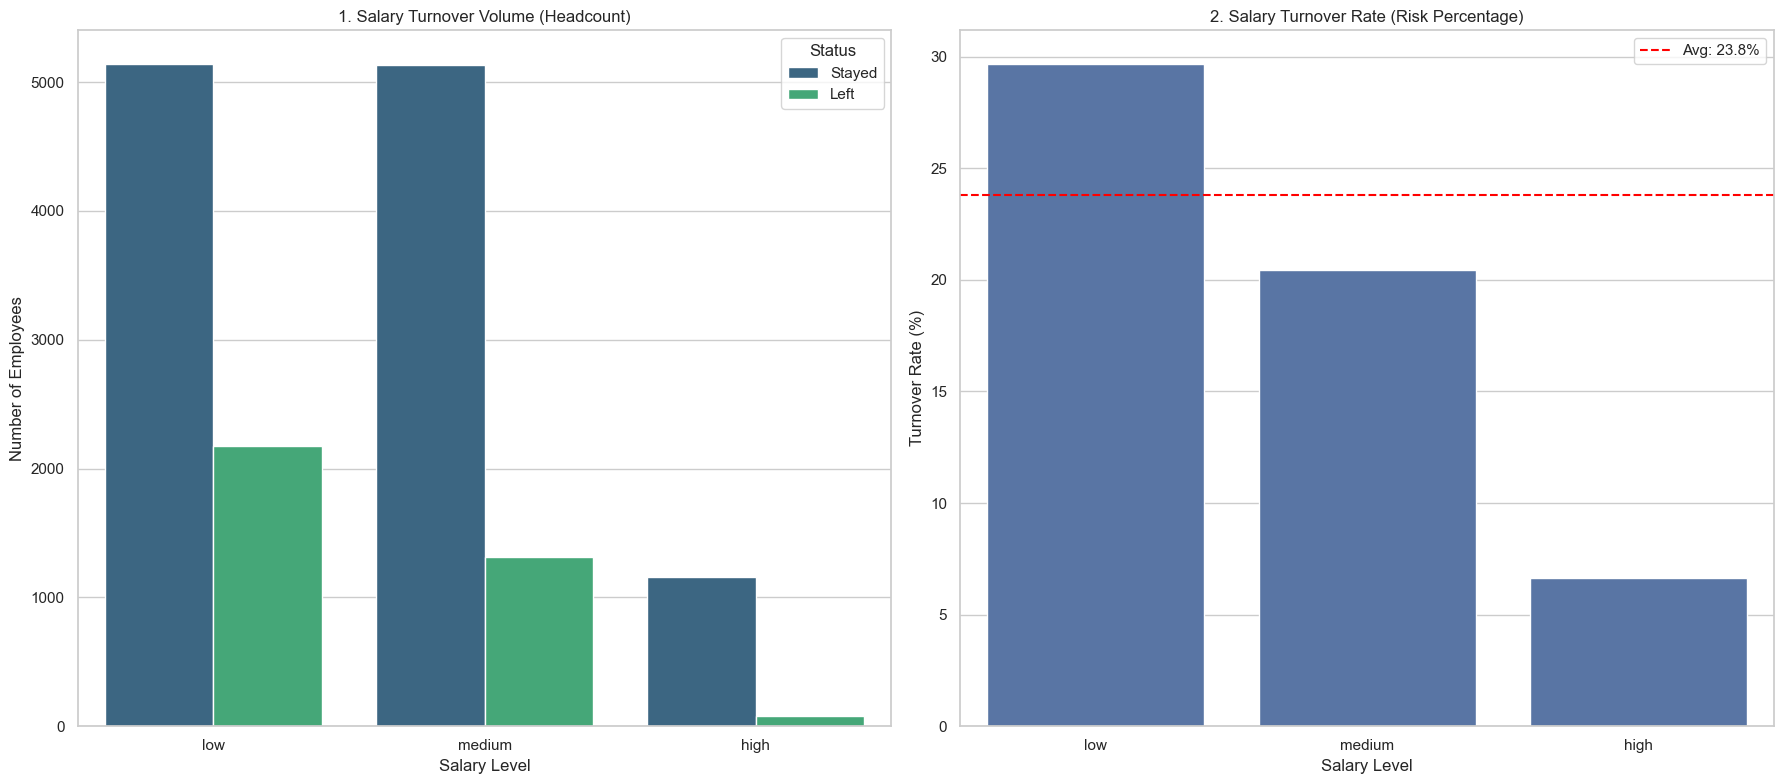

Turnover Rate by Salary:
| Salary   |   Turnover_Rate |
|:---------|----------------:|
| low      |            29.7 |
| medium   |            20.4 |
| high     |             6.6 |


In [50]:
# 3.3 Salary Analysis: Volume vs. Rate
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Define the logical order for salary (Low -> High)
salary_order = ['low', 'medium', 'high']

# --- Chart 1: The Volume (Count) ---
sns.countplot(
    x='Salary', 
    hue='Left', 
    data=data, 
    order=salary_order, 
    palette='viridis',
    ax=axes[0]
)
axes[0].set_title('1. Salary Turnover Volume (Headcount)')
axes[0].set_xlabel('Salary Level')
axes[0].set_ylabel('Number of Employees')
axes[0].legend(title='Status', labels=['Stayed', 'Left'])


# --- Chart 2: The Rate (Percentage) ---
# 1. Calculate rates
salary_counts = data.groupby(['Salary', 'Left']).size().unstack()
salary_counts['Turnover_Rate'] = (salary_counts[1] / (salary_counts[0] + salary_counts[1])) * 100

# 2. Reindex to ensure the bars are in the correct Low -> High order
salary_counts = salary_counts.reindex(salary_order)

sns.barplot(
    x=salary_counts.index, 
    y=salary_counts['Turnover_Rate'], 
    order=salary_order,
    ax=axes[1]
)
axes[1].set_title('2. Salary Turnover Rate (Risk Percentage)')
axes[1].set_xlabel('Salary Level')
axes[1].set_ylabel('Turnover Rate (%)')

# Add average line for context
avg_turnover = (data['Left'].mean() * 100)
axes[1].axhline(avg_turnover, color='red', linestyle='--', label=f'Avg: {avg_turnover:.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print the exact numbers to confirm
print("Turnover Rate by Salary:")
print(salary_counts['Turnover_Rate'].to_markdown(floatfmt=".1f"))

**Volume vs Rate**  
 The chart on the left displays a count for each salary level which may sometimes lead to misintepretation by viewers. In order to avoid this, the chart on the right displays the turnover rate for each department. Observing the chart we can see that despite the low and medium salary levels have similar count, we can see that low salary employees face a higher turnover rate, likely meaning that employees could benefit from higher compensation

### 3.4 Turnover by Tenure

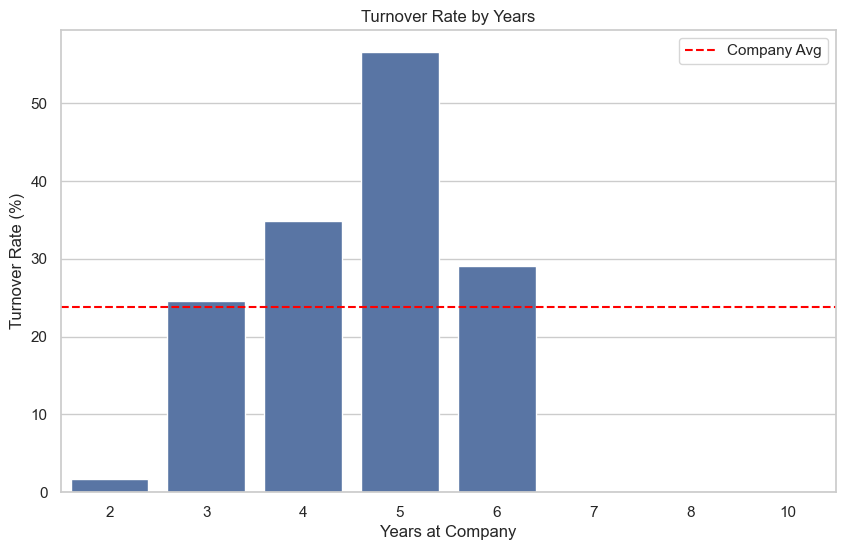

In [51]:
# 3.4 Turnover Rate by Tenure
plt.figure(figsize=(10, 6))

# Calculate rates
tenure_metrics = data.groupby('TimeSpentAtCompany')['Left'].mean().reset_index()
tenure_metrics['Left'] = tenure_metrics['Left'] * 100 # Convert to percentage

sns.barplot(x='TimeSpentAtCompany', y='Left', data=tenure_metrics)

plt.title('Turnover Rate by Years')
plt.xlabel('Years at Company')
plt.ylabel('Turnover Rate (%)')
plt.axhline(data['Left'].mean()*100, color='red', linestyle='--', label='Company Avg')
plt.legend()
plt.show()

**Year 3 Retention Program**  
Due to the increase in employee turnover rate in years 4-5, HR should intervine during the 3rd year of employment with either:
1. promotions
2. raises
3. rotation programs  

### 3.5 Coorelation Between Workload and Retention

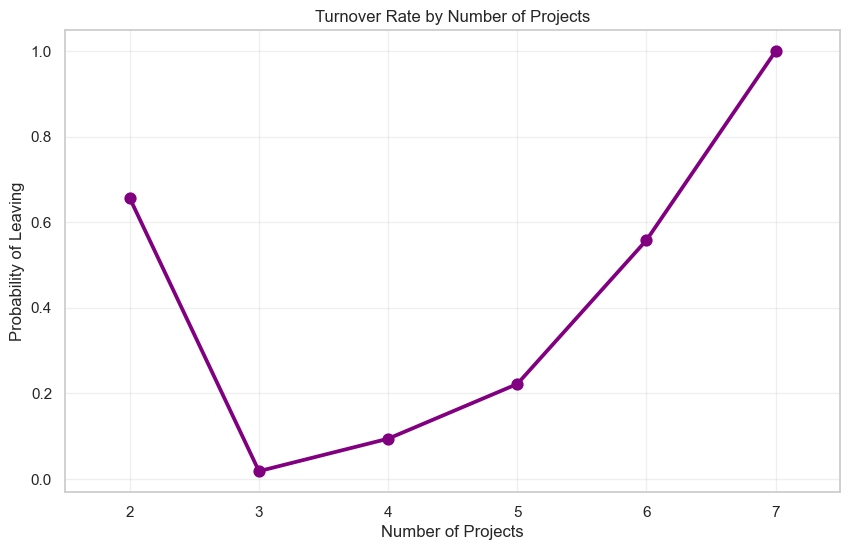

In [52]:
# 3.5 Turnover vs. Number of Projects
plt.figure(figsize=(10, 6))

# We use a pointplot here to show the "U-Shaped" curve clearly
sns.pointplot(x='NumberofProjects', y='Left', data=data, color='purple', errorbar=None)

plt.title('Turnover Rate by Number of Projects')
plt.xlabel('Number of Projects')
plt.ylabel('Probability of Leaving')
plt.grid(True, alpha=0.3)
plt.show()

**Sweet Spot for Project**  
 Employees handling between 3-5 projects have a significanly lower turnover rates. This is because any lower than 3 may lead to boredom in an employee, and handling a excessivly high number of projects, over 6, can lead to potential burnout.


### 3.6 Overall Workload Distribution

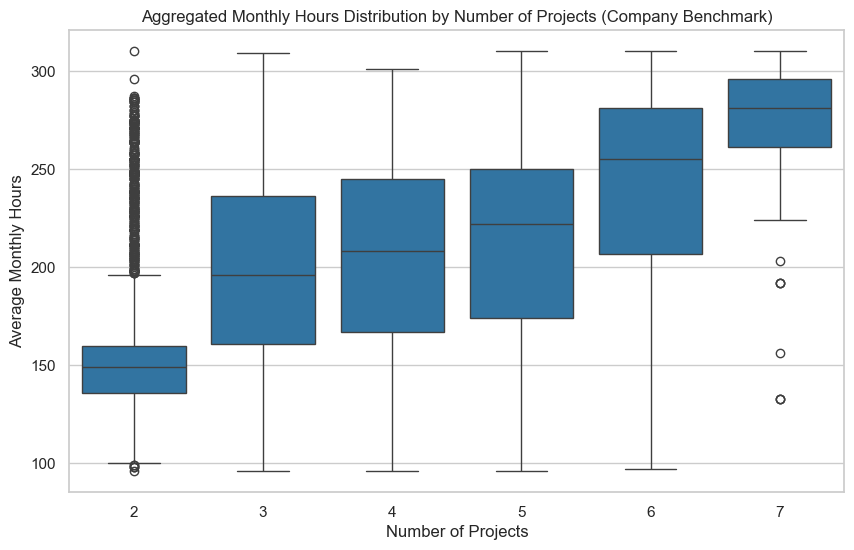

In [53]:
# 3.6 Projects vs. Monthly Hours (Aggregated)

plt.figure(figsize=(10, 6))
# Removing the 'hue' argument aggregates the data for each project level
sns.boxplot(
    x='NumberofProjects', 
    y='AverageMonthlyHours', 
    data=data, 
    color='tab:blue'
)
plt.title('Aggregated Monthly Hours Distribution by Number of Projects (Company Benchmark)')
plt.xlabel('Number of Projects')
plt.ylabel('Average Monthly Hours')
plt.show()

**Aggregated Workload Insight**
This chart establishes the baseline for how workload is distributed across the organization. The key takeaways are:
 
* **Linear Relationship:** There is a clear, nearly linear relationship between the number of projects and the median hours worked.
* **Peak Workload:** The highest median hours worked is for employees with **7 projects**.
* **Context:** This chart is essential context for the attrition analysis, as it shows what is considered 'normal' workload for the organization before diving into the specific attrition risk factors.
 
**Synthesis:** This chart confirms that the project volume identified in the previous **Project Load vs. Tunover Rate** analysis corresponds to a moderate workload for the "Goldilocks Zone." **Crucially, managing project assignments to remain within the 3-5 project zone directly enables management to contain Average Monthly Hours within a moderate, less stressful range, therby lowering burnout risk.** The high median hours at 6 and 7 projects sets the stage for the final analysis, where this excessive workload defines the high-risk 'Burned Out" cluster.

### 3.7 Satisfaction Level Distribution

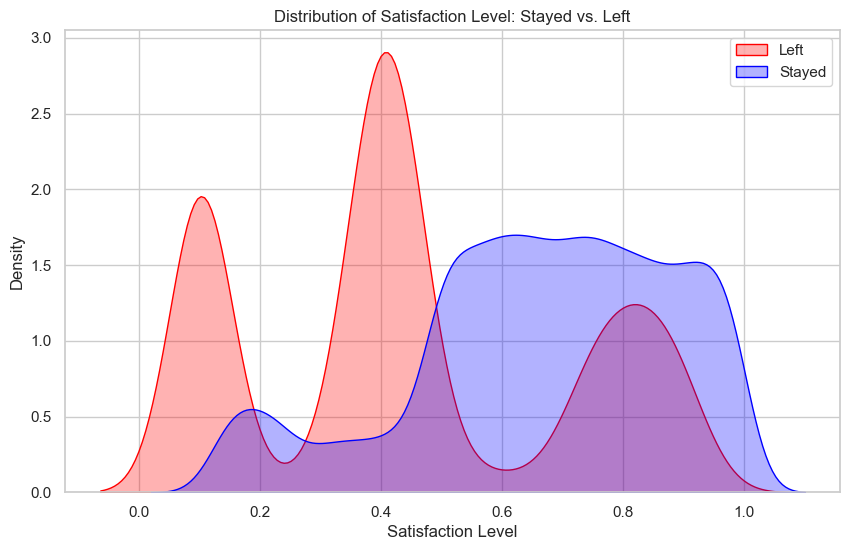

In [54]:
# 3.7 Satisfaction Level Distribution (KDE Plot)
plt.figure(figsize=(10, 6))

sns.kdeplot(data=data[data['Left'] == 1]['SatisfactionLevel'], label='Left', fill=True, color='red', alpha=0.3)
sns.kdeplot(data=data[data['Left'] == 0]['SatisfactionLevel'], label='Stayed', fill=True, color='blue', alpha=0.3)

plt.title('Distribution of Satisfaction Level: Stayed vs. Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Density')
plt.legend()
plt.show()

**Observation:**
The Kernel Density Estimation (KDE) plot reveals a critical insight: turnover is not linear. If turnover were driven solely by unhappiness, we would see a single spike on the left side of the chart. Instead, the "Left" distribution (Red curve) is **tri-modal**, displaying three distinct groups of employees leaving the company:
 
1. **Extremely Dissatisfied (Peak at ~0.1):** A large group of employees are leaving with near-zero satisfaction scores, indicating a severe disconnect with the company.
2. **Moderately Dissatisfied (Peak at ~0.4):** A second distinct group exists in the lower-middle range, suggesting a different set of friction points than the first group.
3. **The "Happy Leaver" Paradox (Peak at ~0.8):** Most concerningly, there is a significant spike of employees leaving despite having **high satisfaction levels**. This contradicts the assumption that "happy employees stay" and suggests that factors outside of satisfaction are driving this specific group away.
 
**Next Step:**
Since satisfaction levels alone cannot explain *why* these three distinct groups are formed, we must next layer in **Workload (Hours)** and **Performance (Evaluations)** to profile these groups accurately.

### 3.8 Satisfaction vs Evaluation/Hours

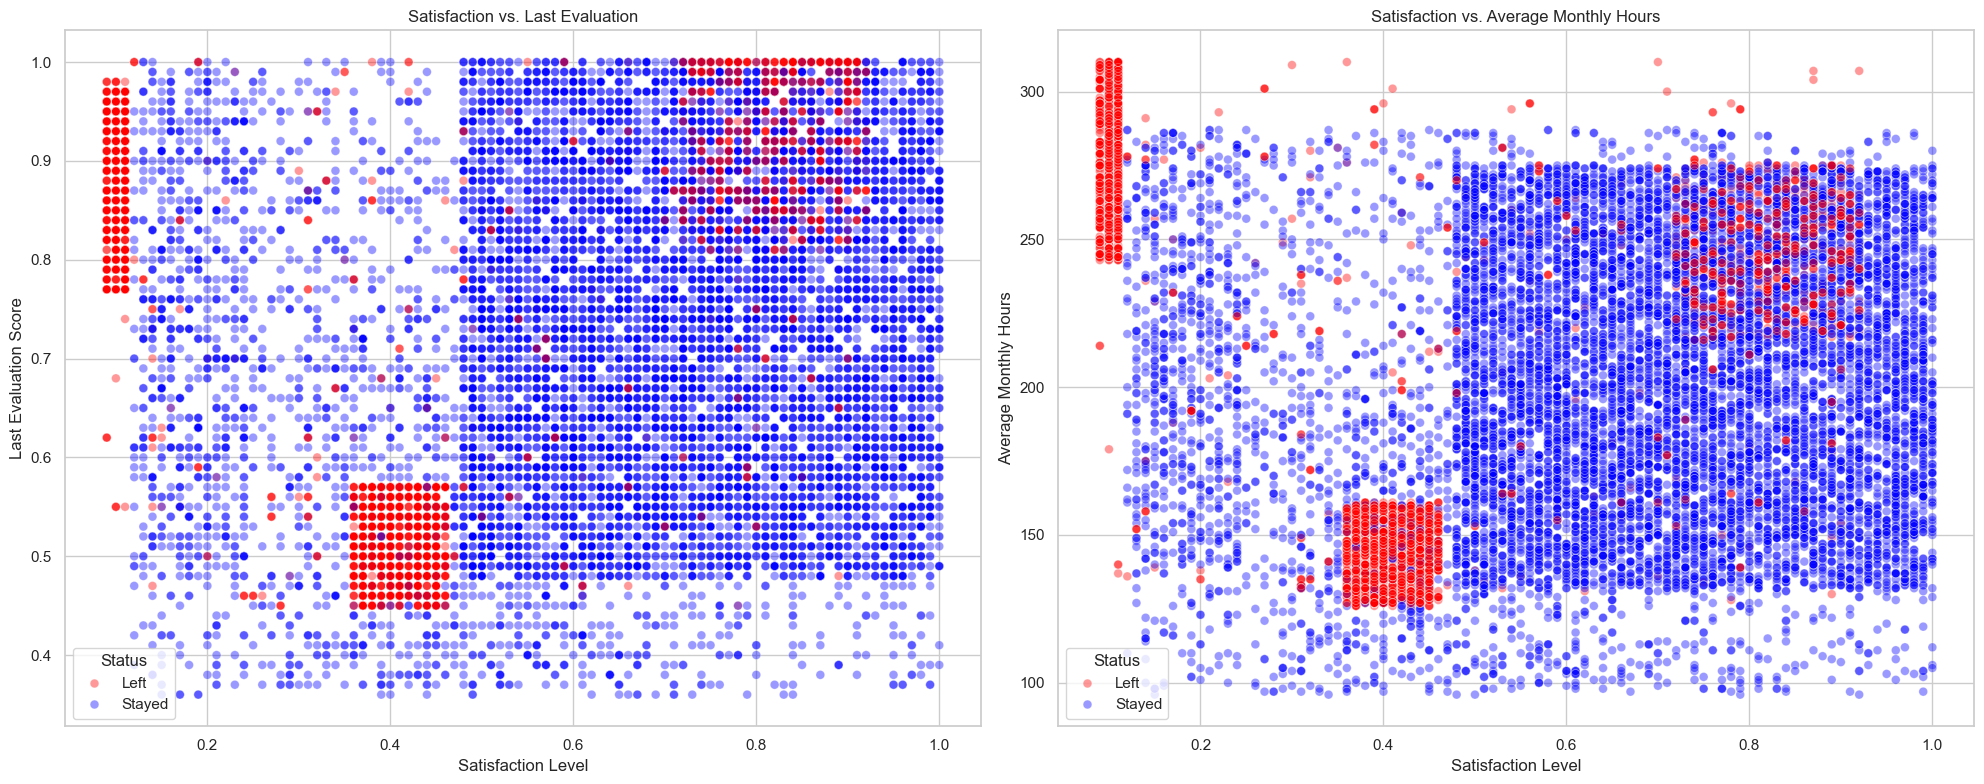

In [55]:
# 3.7 Side-by-Side EDA Comparison

# 1. Create a temporary column with readable labels
data['Status'] = data['Left'].map({0: 'Stayed', 1: 'Left'})

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Define colors: Stayed = Blue, Left = Red
custom_palette = {'Stayed': 'blue', 'Left': 'red'}

# --- Chart 1: Satisfaction vs. Evaluation (Left Side) ---
sns.scatterplot(
    x='SatisfactionLevel', 
    y='LastEvaluation', 
    hue='Status', 
    data=data, 
    palette=custom_palette, 
    alpha=0.4, 
    s=40,
    ax=axes[0]
)
axes[0].set_title('Satisfaction vs. Last Evaluation')
axes[0].set_xlabel('Satisfaction Level')
axes[0].set_ylabel('Last Evaluation Score')
# Force legend to bottom left
axes[0].legend(loc='lower left', title='Status', frameon=True)


# --- Chart 2: Satisfaction vs. Monthly Hours (Right Side) ---
sns.scatterplot(
    x='SatisfactionLevel', 
    y='AverageMonthlyHours', 
    hue='Status', 
    data=data, 
    palette=custom_palette, 
    alpha=0.4, 
    s=40,
    ax=axes[1]
)
axes[1].set_title('Satisfaction vs. Average Monthly Hours')
axes[1].set_xlabel('Satisfaction Level') 
axes[1].set_ylabel('Average Monthly Hours')
axes[1].legend(loc='lower left', title='Status', frameon=True)


plt.tight_layout()
plt.show()

# Clean up: Drop the helper column so it doesn't duplicate data later
data.drop('Status', axis=1, inplace=True)

**Coorelation between AVG monthly hours and Evaluation Score**  
Despite the charts above representing different factors on the y-axis, we can see that the values and clusters remain in the same general area. This shows a direct coorelation between the hours an employee puts in and their evaluation score. We also see 3 distinct clusters between the employees who left.
1. **Burned Out** (top left)
    * **Profile:** Satisfaction < 0.2 | Evaluation > 0.75 | Hours > 250
    * **Diagnosis:** These are high-performing employees who were severely overworked. Their "crash" in satisfaction (to ~0.1) is directly correlated with working significantly more hours than the company average.
2. **Underperformers** (lower)
    * **Profile:** Satisfaction ~ 0.4 | Evaluation < 0.55 | Hours < 160
    * **Diagnosis:** This group corresponds to the "Underperformer" peak. They worked the fewest hours and received low evaluation scores, indicating a lack of engagement or "Quiet Quitting."
3. **Superstars** (top right)
    * **Profile:** Satisfaction > 0.7 | Evaluation > 0.8 | Hours > 220
    * **Diagnosis:** This explains the "Happy Leaver" paradox. These employees were highly productive and put in long hours, yet remained satisfied. Their departure suggests they were likely poached by competitors offering better compensation or growth, rather than fleeing a bad work environment.
 
Our analysis reveals that turnover is not random; it is driven by three specific structural failures: Overworking our best talent (Burnout), failing to manage poor performers (Mismatched), and failing to retain happy high-achievers (likely Compensation/Growth issues).


## Step 4: Data Processing

In [56]:
# --- Step 4: Data Preprocessing  ---
print("--- Step 4: Data Preprocessing ---")

# Define our target variable (y) and features (X)
target = 'Left'

# We only drop the target itself ('Left')
features = data.drop([target], axis=1) 
y = data[target]

# Identify numerical and categorical features
numeric_features = [
    'SatisfactionLevel', 
    'LastEvaluation', 
    'NumberofProjects', 
    'AverageMonthlyHours', 
    'TimeSpentAtCompany', 
    'PromotionsInLast5Years',
    'WorkAccident'
]

categorical_features = ['Department', 'Salary']

print(f"Target variable: {target}")
print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}\n")

# Create a preprocessing pipeline
# 1. For numeric features: Scale them
numeric_transformer = StandardScaler()

# 2. For categorical features: One-Hot Encode them
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Use ColumnTransformer to apply transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessing pipeline created.")
print("-" * 40 + "\n")

--- Step 4: Data Preprocessing ---
Target variable: Left
Numeric features: ['SatisfactionLevel', 'LastEvaluation', 'NumberofProjects', 'AverageMonthlyHours', 'TimeSpentAtCompany', 'PromotionsInLast5Years', 'WorkAccident']
Categorical features: ['Department', 'Salary']

Preprocessing pipeline created.
----------------------------------------



## Step 5: Model Training and Evaluation

### 1. Train-Test Split

In [57]:
# --- Step 5: Split Data ---
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set:  {X_test.shape[0]} samples")

Training set: 11999 samples
Testing set:  3000 samples


### 2. Model Training and Evaluation

In [58]:
# --- Step 5.2: Model Implementation ---

models = {
    "SVM": SVC(kernel='linear', random_state=42),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=600, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Pipeline: Preprocess -> Train
    clf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    clf_pipeline.fit(X_train, y_train)
    y_pred = clf_pipeline.predict(X_test)
    
    # Metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

print("\nTraining Complete.")

Training SVM...
Training MLP (Neural Net)...
Training Decision Tree...
Training Random Forest...

Training Complete.


## Step 6: Model Comparison

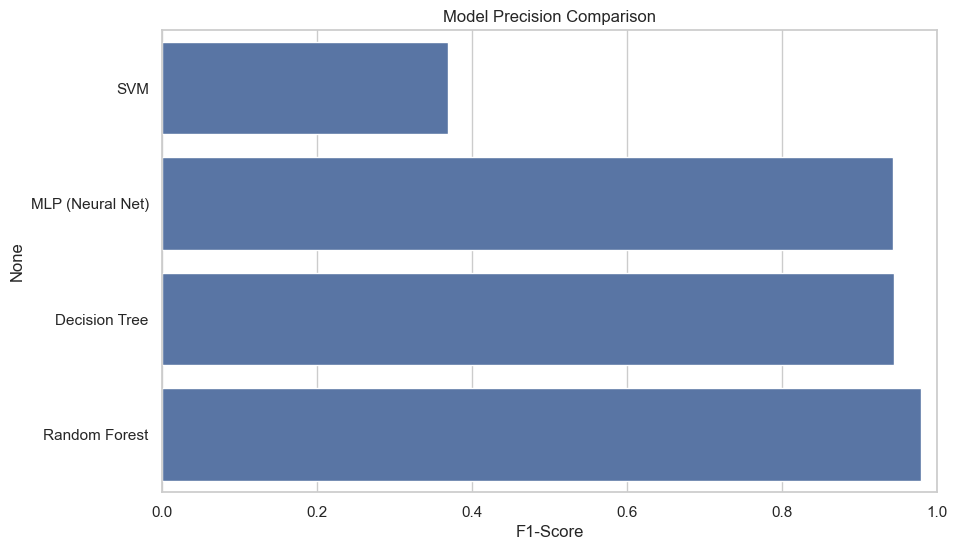

Detailed Performance Metrics:


,Accuracy,Precision,Recall,F1-Score
SVM,0.782667,0.596875,0.267507,0.369439
MLP (Neural Net),0.973333,0.946479,0.941176,0.943820
Decision Tree,0.973333,0.926075,0.964986,0.945130
Random Forest,0.990333,0.995658,0.963585,0.979359


In [59]:
# --- Step 6: Model Comparison ---
results_df = pd.DataFrame(results).T

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df['F1-Score'], y=results_df.index)
plt.title('Model Precision Comparison')
plt.xlim(0, 1.0)
plt.show()

# Display Table
print("Detailed Performance Metrics:")
display(results_df) #prints table

**Accuracy:** How often is the model correct?  
**Precision:** When the model predicts someone will leave, how often is it correct?  
**Recall:** Out of the people who quit, what percentage did the model catch beforehand?  
**F1-Score:** How reliable is the model?

### Visualization of Prediction Results

--- Visualizing Confusion Matrix for Random Forest ---


<Figure size 800x600 with 0 Axes>

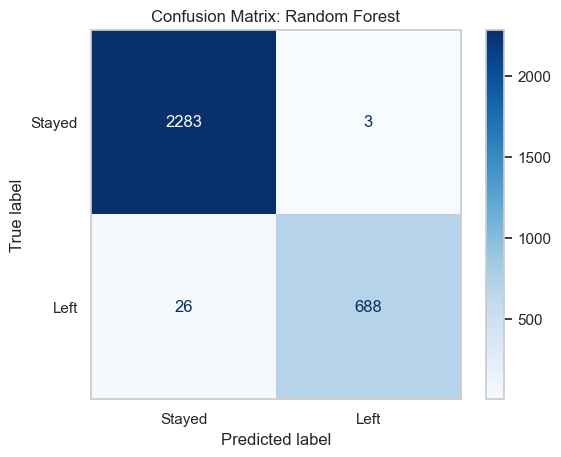

In [60]:
# --- Visualization: Confusion Matrix (Random Forest) ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("--- Visualizing Confusion Matrix for Random Forest ---")

# build and train the Random Forest pipeline 
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)

# 1. Generate predictions using the fitted Random Forest pipeline from Step 6
y_pred_rf = rf_pipeline.predict(X_test)

# 2. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# 3. Plot the matrix
plt.figure(figsize=(8, 6))
# display_labels maps 0 to 'Stayed' and 1 to 'Left' for clarity
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stayed', 'Left'])
disp.plot(cmap='Blues', values_format='d') # 'd' formats numbers as integers (no scientific notation)

plt.title('Confusion Matrix: Random Forest')
plt.grid(False) # Turn off grid lines for cleaner look
plt.show()

Recall would be shown on the bottom row, while precision is shown on the right column

## Step 7: Feature Importance Analytics

--- Step 7: Feature Importance Analysis (from Random Forest) ---
Top 10 factors influencing employee retention:
| Feature              |   Importance |
|:---------------------|-------------:|
| SatisfactionLevel    |       0.3023 |
| NumberofProjects     |       0.1803 |
| TimeSpentAtCompany   |       0.1795 |
| AverageMonthlyHours  |       0.1631 |
| LastEvaluation       |       0.1270 |
| WorkAccident         |       0.0095 |
| Salary_low           |       0.0064 |
| Salary_high          |       0.0055 |
| Department_technical |       0.0039 |
| Salary_medium        |       0.0037 |


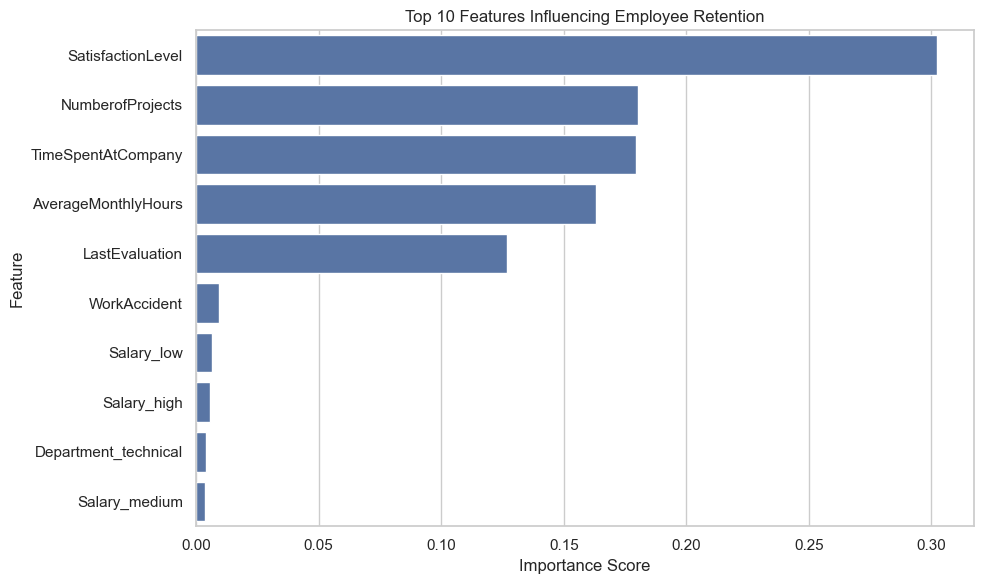

In [61]:
# --- Step 7: Feature Importance Analysis ---
print("--- Step 7: Feature Importance Analysis (from Random Forest) ---")

# --- Extract Feature Names ---
# 1. Get the categorical names after OneHotEncoding
cat_feature_names = rf_pipeline.named_steps['preprocessor'] \
                               .named_transformers_['cat'] \
                               .get_feature_names_out(categorical_features)

# 2. Combine with the numeric features
all_feature_names = numeric_features + list(cat_feature_names)

# --- Extract Importances ---
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the Top 10
print("Top 10 factors influencing employee retention:")
print(feature_importance_df.head(10).to_markdown(index=False, floatfmt=".4f"))

# --- Visualization: Feature Importance ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Features Influencing Employee Retention')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Step 8: Prediction Probabilities

In [62]:
# --- Step 8: Employee Risk Scoring ---
print("--- Step 8: Employee Risk Scoring ---")

# 1. Get probability scores
risk_scores = rf_pipeline.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame to analyze these scores
risk_df = X_test.copy()
risk_df['Risk_Score'] = risk_scores
risk_df['Actual_Status'] = y_test 

# --- Filter for ONLY Current Employees ---
# We only want to look at people who are currently at the company (Actual_Status == 0)
current_employee_risk = risk_df[risk_df['Actual_Status'] == 0].copy()

# 3. Segment employees into groups (Low, Medium, High Risk)
def categorize_risk(score):
    if score < 0.3:
        return 'Low Risk'
    elif score < 0.7:
        return 'Medium Risk'
    else:
        return 'High Risk'

current_employee_risk['Risk_Group'] = current_employee_risk['Risk_Score'].apply(categorize_risk)

# 4. Display ALL "High Risk" Current Employees
print("High Risk Employees:")
print(current_employee_risk[current_employee_risk['Risk_Group'] == 'High Risk'].sort_values(by='Risk_Score', ascending=False).to_markdown())

# 5. Analyze the High Risk Group
high_risk_employees = current_employee_risk[current_employee_risk['Risk_Group'] == 'High Risk']
print(f"\nNumber of CURRENT employees identified as High Risk: {len(high_risk_employees)}")

--- Step 8: Employee Risk Scoring ---
High Risk Employees:
|      |   SatisfactionLevel |   LastEvaluation |   NumberofProjects |   AverageMonthlyHours |   TimeSpentAtCompany |   WorkAccident |   PromotionsInLast5Years | Department   | Salary   |   Risk_Score |   Actual_Status | Risk_Group   |
|-----:|--------------------:|-----------------:|-------------------:|----------------------:|---------------------:|---------------:|-------------------------:|:-------------|:---------|-------------:|----------------:|:-------------|
| 6358 |                0.81 |             0.98 |                  5 |                   243 |                    6 |              0 |                        0 | sales        | medium   |         0.98 |               0 | High Risk    |
| 6263 |                0.9  |             0.87 |                  4 |                   231 |                    5 |              0 |                        0 | management   | low      |         0.91 |               0 | High Risk   

--- Step 9: Risk Scoring Current Employees ---
High Risk Current Employees identified: 3


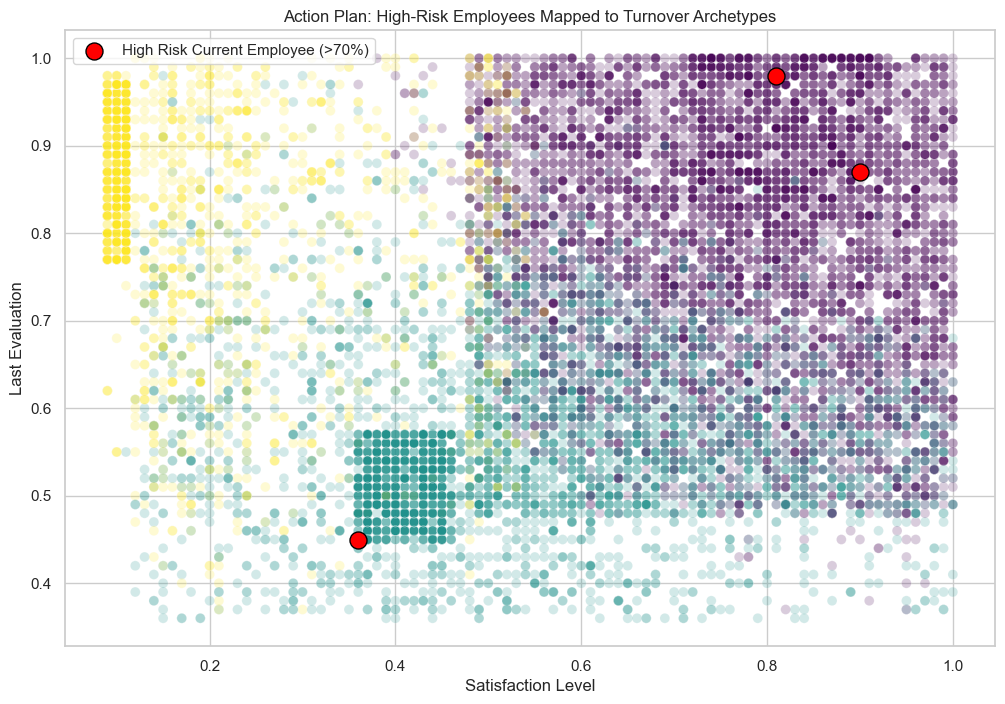

Actionable List (High Risk):
|      | Department   |   SatisfactionLevel |   LastEvaluation |   Risk_Score |
|-----:|:-------------|--------------------:|-----------------:|-------------:|
| 6358 | sales        |                0.81 |             0.98 |         0.98 |
| 6263 | management   |                0.9  |             0.87 |         0.91 |
| 7989 | support      |                0.36 |             0.45 |         0.76 |


In [63]:
# --- Step 9: Global Cluster Analysis (The "Ghost Map") ---
from sklearn.cluster import KMeans

# 1. Select Features for Clustering
# We use these three because they visually define the "Leaver" profiles best
cluster_features = ['SatisfactionLevel', 'LastEvaluation', 'AverageMonthlyHours']
X_clustering = data[cluster_features].copy()

# 2. Scale the data (Crucial for K-Means)
cluster_scaler = StandardScaler()
X_scaled = cluster_scaler.fit_transform(X_clustering)

# 3. Fit K-Means & Create the Column
# This fixes your error! We are creating the 'Archetype_Cluster' column here.
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data['Archetype_Cluster'] = kmeans.fit_predict(X_scaled)

# --- Step 8: Risk Scoring & Action Plan Chart ---
print("--- Step 9: Risk Scoring Current Employees ---")

# 1. Isolate Current Employees
current_employee_mask = data['Left'] == 0
current_employees = data[current_employee_mask].copy()

# 2. Prepare Data for Prediction (Safety Step)
# We filter to only the columns the model was trained on to prevent errors
training_features = list(rf_pipeline.named_steps['preprocessor'].feature_names_in_)
X_current_clean = current_employees[training_features]

# 3. Generate Probabilities
risk_probs = rf_pipeline.predict_proba(X_current_clean)[:, 1]

# 4. Assign Scores back to the Dataframe
data.loc[current_employee_mask, 'Risk_Score'] = risk_probs
data['Risk_Score'] = data['Risk_Score'].fillna(0)

# 5. Identify "High Risk" Current Employees (> 70%)
high_risk_mask = (data['Left'] == 0) & (data['Risk_Score'] > 0.7)
print(f"High Risk Current Employees identified: {high_risk_mask.sum()}")

# 6. Chart 2: The Action Plan (Red Dots)
plt.figure(figsize=(12, 8))

# Layer 1: Background Context (Faint)
sns.scatterplot(
    x='SatisfactionLevel', 
    y='LastEvaluation', 
    hue='Archetype_Cluster', 
    data=data, 
    palette='viridis', 
    s=50, 
    alpha=0.2,            # Faded background
    legend=False
)

# Layer 2: High Risk Current Employees (Bright Red)
sns.scatterplot(
    x='SatisfactionLevel',
    y='LastEvaluation',
    data=data[high_risk_mask],
    color='red',
    marker='o',
    s=150,                # Big dots
    edgecolor='black',
    label='High Risk Current Employee (>70%)'
)

plt.title('Action Plan: High-Risk Employees Mapped to Turnover Archetypes')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.legend(loc='upper left')
plt.show()

# Display the High Risk list
print("Actionable List (High Risk):")
cols_to_show = ['Department', 'SatisfactionLevel', 'LastEvaluation', 'Risk_Score']
print(data[high_risk_mask].sort_values('Risk_Score', ascending=False)[cols_to_show].head(5).to_markdown())

## Final Executive Recommendation: Targeted Intervention Plan

**The Situation:**
Applying our Predictive Model (Random Forest) to the current employee roster, we have identified **3 specific employees** who currently hold a **>70% probability of leaving** the company.

1. **The Superstars** (2 Employees)
* **Location:** Top-Right Purple Cluster (High Satisfaction, High Evaluation).
* **Diagnosis:** These distinct red dots represent our top talent. They are performing well and are generally satisfied, yet the model flags them as high risk. This indicates they are likely being **poached** by competitors offering higher salaries or better titles.
* **Action Plan:** **Immediate Retention.**    * Do not offer "culture" fixes (they are already happy). 
  * HR should immediately review their compensation packages and career paths. 
  * **Recommendation:** Conduct a "Stay Interview" this week and be prepared to counter-offer.

2. **The Mismatched** (1 Employee)
* **Location:** Bottom-Middle Teal Cluster (Low Satisfaction, Low Evaluation).
* **Diagnosis:** This employee is disengaged, working low hours, and performing poorly. They fit the "Quiet Quitting" profile.
* **Action Plan:** **Performance Management.**
  * Spending retention budget here would be a waste of resources.
  * **Recommendation:** Place this employee on a Performance Improvement Plan (PIP). If performance does not improve, allow natural attrition to occur.

**Summary:**
We have moved from reactive analysis to proactive prevention. By focusing our efforts on the **two "Superstars"** identified above, we can protect the company's most valuable assets while avoiding unnecessary spending on the "Mismatched" case.

